# Introduction

We plan to investigate the generation of financial time series using the TimeGAN model proposed by Yoon, Jarrett and van der Schaar. The generation of financial time series introduces an additional complexity compared to the generation of images, which is the problem GANs were designed to solve (Goodfellow et al., 2014). The image generation task does not explicitly require capturing conditional distributions $p(\boldsymbol{x}_t \mid \boldsymbol{x}_{1:t-1})$, given sequential time-series data of the form $\boldsymbol{x}_{1:t} = (x_1, \dots, x_t)$; instead, image generation only requires learning a joint distribution of the form $p(\boldsymbol{x}_{1:t})$. In other words, traditional GANs such as FinGAN learn the distribution of features *within* each time point by treating the time-series as a random vector and learning its joint probability distribution, but they do not necessarily learn the distribution of features *between* time points. The TimeGAN model seeks to address this deficiency, by explicitly learning the conditional distributions $p(\boldsymbol{x}_t \mid \boldsymbol{x}_{1:t-1})$ present in the data. The authors did not specifically seek to model financial time series, but they find that the feature of TimeGAN is particularly helpful for generated stock price data, which tend to have high serial correlation.
 
Aside from being an interesting problem from the perspective of deep learning, we mention but two examples of applications of a generative model for financial time series. If we can generate realistic prices, we can use these to train neural network option pricing models, instead of, for example, having to obtain real option price data or sampling synthetic price paths from a geometric Brownian motion. Another application can be as a market scenario generator. If we can generate realistic price series for a number of different assets which also captures interactions between those assets, or if we can generate time series of economic variables such as GDP, unemployment and inflation, then we are able to generate realistic market scenarios to further economic understanding or e.g. perform stress tests.

To briefly summarise our findings, we found that TimeGAN trains fairly smoothly, with the generator learning quickly in the first few epochs but very little in the remaining epochs. TimeGAN seems to be able to generate time series which exhibit volatility clustering.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader
from torch.nn import functional as F
torch.manual_seed(0) 

from sklearn.preprocessing import MinMaxScaler
from d2l import torch as d2l
import random
from sklearn.manifold import TSNE 
from sklearn.decomposition import PCA
import statsmodels.api as sm

plt.rcParams["figure.figsize"] = (14, 5)

# Data
 
We use [a dataset from Kaggle](https://www.kaggle.com/datasets/camnugent/sandp500).

### Data preprocessing

Ideally, we would be able to use each time series of length 1259 to train TimeGAN. However, we cannot generate such long time series without significant computing power. Hence, we choose to generate time series of length 255 instead. This number was chosen since it is the number of trading days in one year, and should still be long enough to observe volatility clustering and heavy tails. 255 is significantly longer than the length of time series generated by the TimeGAN author's implementation on GitHub; they only generate time series of length 24.

#### Cleaning
We clean the dataset by first selecting stocks with exactly 1259 trading days worth of data, since some stocks have fewer trading days of data. Then, we only keep data for the first six stocks, since the authors of the TimeGAN paper used a 6-variate time series in their experiements with stock data. Using data for significantly more stocks would result in TimeGAN having a huge number of estimable parameters, which again requires a lot of computing power.

In [2]:
# Code for transforming 'all_stocks_5yr.csv' from the data source
'''
# Determine which symbols to ignore, because they're missing data
all_symbols = list(set(df['Name'])) # All 505 symbols in dataset
symbols = [] # symbols we will use
names = list(df["Name"]) 
for symbol in all_symbols:
    # The length of the price series for most symbols is 1259
    if names.count(symbol) == 1259:
        symbols.append(symbol)

# Extract close price series from dataframe
num_series = 6 # number of close price series to extract (can extract up to 470)
paths = []
for symbol in symbols:
    path = list(df[df["Name"] == symbol]["close"])
    paths.append(path)
    if len(paths) > num_series-1:
        break
paths = torch.tensor(np.array(paths)).T

# Shape of tensor for stocks with full data available
paths.shape
'''

'\n# Determine which symbols to ignore, because they\'re missing data\nall_symbols = list(set(df[\'Name\'])) # All 505 symbols in dataset\nsymbols = [] # symbols we will use\nnames = list(df["Name"]) \nfor symbol in all_symbols:\n    # The length of the price series for most symbols is 1259\n    if names.count(symbol) == 1259:\n        symbols.append(symbol)\n\n# Extract close price series from dataframe\nnum_series = 6 # number of close price series to extract (can extract up to 470)\npaths = []\nfor symbol in symbols:\n    path = list(df[df["Name"] == symbol]["close"])\n    paths.append(path)\n    if len(paths) > num_series-1:\n        break\npaths = torch.tensor(np.array(paths)).T\n\n# Shape of tensor for stocks with full data available\npaths.shape\n'

In [3]:
paths_raw = pd.read_csv("https://raw.githubusercontent.com/sanj909/Timeseries-GANs/main/transformed_data.csv")

In [4]:
paths = torch.tensor(np.array(paths_raw))
paths.shape

torch.Size([1259, 6])

#### Scaling
We now scale the data, which will preserves the properties of the data and help with the training process. Also, different stocks trade in different price ranges, so scaling will allow us to use price series for more stocks (after scaling, all price series are essentially homogeneous)

To do this, we use the MinMaxScaler from the "sklearn" package, which has the following description: "The estimator scales and translates each feature individually such that it is in the given range on the training set, e.g. between zero and one."

In [5]:
def scale(data):
    scaler = MinMaxScaler()
    scaled_data = scaler.fit_transform(data)
    return scaler, scaled_data

In [6]:
scaler, paths_scaled = scale(paths)
paths_scaled.shape

(1259, 6)

#### Extract Rolling windows

Right now, we have six series of length 1259. However, we wish to generate sequences of length 255. Hence, we extract rolling windows of length 255 from our data. That is, for each of the six stocks we have data for, we will end up with 1259-255 = 1004 series, each of length 255, which we use as training data.

In [7]:
def extract_windows(data, sequence_length):
    '''
        Extract rolling windows of length sequence_length
        from the data

        Input: numpy array
        Returns: torch tensor
    '''
    X = []
    for i in range(len(data) - sequence_length):
        X.append(data[i:i + sequence_length].astype(np.float32))
    return torch.tensor(np.array(X))

In [8]:
X = extract_windows(paths_scaled, sequence_length=255)
X.shape

torch.Size([1004, 255, 6])

In [9]:
input_size = paths_scaled.shape[1]
'''
Number of variates in time series. 
E.g. for OHLC data, input_size=4
In our case, input_size=6
'''
sequence_length = 255
'''
Number of values in each variate in the (multivariate) time series. 
I.e. length of sequences we want the trained model to generate
'''
batch_size = 128
'''
A free hyperparameter.
Same batch size that was used by Yoon; it yielded good results
according to the TimeGAN paper, so we use the same.
'''

'\nA free hyperparameter.\nSame batch size that was used by Yoon; it yielded good results\naccording to the TimeGAN paper, so we use the same.\n'

In [10]:
train_data = TensorDataset(X, torch.ones(len(X), 1))
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size, drop_last=True)

In [11]:
# Shape of input (X) and output (y)
for _X_, y in train_loader:
    print(_X_.shape, y.shape)
    break

torch.Size([128, 255, 6]) torch.Size([128, 1])


# TimeGAN

As mentioned in the introduction, the TimeGAN model proposed by Yoon, Jarrett and van der Schaar is designed to explictly learn stepwise conditional distributions in time series data. We now summarise the problem formulation for TimeGAN following section 3 of the TimeGAN paper; this then motivates the actual architecture of TimeGAN, which we explain further below. Note that the authors formulate TimeGAN to be able to model non-time series features as well, but we ignore this throughout the following sections as it is not relevant for our application. This results in some of the terms and equations being slightly different to those in the TimeGAN paper.

### Problem Formulation

Let $\mathcal{X}$ be a vector space of temporal features, and let $\boldsymbol{X}_{1:T} \in \mathcal{X}$ be a random vector from this space. I.e. we have that $\boldsymbol{x}_{1:T} = (\boldsymbol{x}_1, \dots, \boldsymbol{x}_T)$ is a (multivariate) time series, and it is a specific realisation of the random variable $\boldsymbol{X}_{1:T}$.

Our training set consists of $N$ of these specific realisations, so that we can denote the training set $\mathcal{D} = \{\boldsymbol{x}_{1:T}^{(n)}\}_{n=1}^{N}$. In our case, we have chosen $T=255$ as the fixed length of each training example, though in principle TimeGAN can deal with variable length sequences. Going forwards, we omit the supercript $(n)$ unless it is necessary. 

The goal is to use training data $\mathcal{D}$ to learn a joint density $\hat{p}(\boldsymbol{X}_{1:T})$ which best approximates the true density $p(\boldsymbol{X}_{1:T})$. To aid with learning $\hat{p}$, the authors additionally make use of the decomposition of the joint density
$$
    p(\boldsymbol{X}_{1:T}) = \Pi_t p(\boldsymbol{X}_{t} \mid \boldsymbol{X}_{1:t-1}) 
$$

for $t \in {1, \dots, T}$. This yields the complementary, simpler goal of using the training data to learn a density $\hat{p}(\boldsymbol{X}_{t} \mid \boldsymbol{X}_{1:t-1})$ which best approximates the true density $p(\boldsymbol{X}_{t} \mid \boldsymbol{X}_{1:t-1})$, at each time $t \in {1, \dots, T}$.

In other words, we have two objectives: first, to learn the joint distribution, and second, to learn the conditional distributions. More formally, the first objective is
$$
    \min_{\hat{p}} D (p(\boldsymbol{X}_{1:T}) \mid \mid \hat{p}(\boldsymbol{X}_{1:T}))
$$
and the second objective is 
$$
    \min_{\hat{p}} \tilde{D} (\hat{p}(\boldsymbol{X}_{t} \mid \boldsymbol{X}_{1:t-1}) \mid \mid p(\boldsymbol{X}_{t} \mid \boldsymbol{X}_{1:t-1}))
$$
for any $t \in {1, \dots, T}$. The first objective is the usual GAN objective, so $D$ denotes the Jensen-Shannon divergence. Since we can use the original data to do supervised learning of the conditional distributions, $\tilde{D}$ denotes the Kullback-Leibler divergence. The objective function of TimeGAN will be proportional to both of the objectives above, which the authors call the GAN objective and the ML objective respectively.

### Model architecture

We now explain the model architecture of TimeGAN following section 4 of the TimeGAN paper, and then following the actual implementation of TimeGAN in TensorFlow by Yoon which can be found on GitHub. The reason for this is that there are significant differences between the TimeGAN paper and the actual implementation of TimeGAN by Yoon.

In the paper, TimeGAN consists of four subnetworks: an *embedding* network and a *recovery* network, in addition to the usual generator and discriminator networks which constitute a GAN. With TimeGAN, the entire adversarial learning process happens within a latent vector space, rather than the vector space of the original data.

#### Embedding and recovery networks
The purpose of the embedding network is to map training examples from their original vector space to a latent space, and the purpose of the recovery network is to map generated time series from the latent space back to the original vector space of the training data. Thus, the embedding and recovery networks together can be thought of as an autoencoder. 

The authors note that this latent space may be lower-dimensional than the latent space, as temporal dynamics of even complex systems are often driven by only a few underlying factors. They also note that the purpose of a (lower-dimensional) latent space is not only efficiency, in the sense that it can be modelled by a network with fewer parameters. In addition, the autoencoder is trained jointly with the other subnetworks in such a way the generator is better able to learn temporal relationships in the latent space. 

In the paper, the embedding network is implemeted via a recurrent neural network (RNN), and the recovery network is implemented via a feedforward neural network at each time step. The authors note that these two networks can be implemented by any architecture as long as they are autoregressive (meaning future values of the time series are predicted based on past values of the time series), and outputs at each time step only depend on previous information (to avoid "looking forward" in time). Indeed, in the implementation on GitHub, Yoon uses a three-layer GRU network to implement both the embedding and recovery network, which we follow in our implementation.

The autoencoder is trained to optimise the reconstruction loss 
$$
    \mathcal{L}_R = \mathbb{E}_{\boldsymbol{X}_{1:T} \sim p} \left[ \sum_t || \boldsymbol{X}_t - \boldsymbol{\tilde{X}}_t ||_2 \right]
$$
where $||\cdot||_2$ is the usual Euclidean norm and $\boldsymbol{\tilde{X}}_t$ is the reconstruction of the input $\boldsymbol{X}_t$ by the autoencoder. In practice, this loss is implemented by calculating the mean squared error between inputs and outputs of the autoencoder, where the mean is taken over all samples in a minibatch.

#### Generator and discriminator networks
The generator and discriminator networks function exactly as in traditional GANs. In the paper, the generator is implemented via a RNN, and the discriminator is implemented via a bidirectional RNN. Once again, in the implementation on GitHub, Yoon uses a three-layer GRU network to implement both the generator and discriminator networks, which we follow in our implementation.

The generator and discriminator are trained to optimise the unsupervised loss 
$$
     \mathcal{L}_U = \mathbb{E}_{\boldsymbol{X}_{1:T} \sim p} \left[ \sum_t \log y_t \right] + \mathbb{E}_{\boldsymbol{X}_{1:T} \sim \hat{p}} \left[ \sum_t \log (1 - \hat{y}_t) \right]
$$
where $y_t$ and $\hat{y}_t$ are the discriminator network's outputs when given real and synthetic data as input, respectively. This is the usual objective function for training GANs, and is implemented using the binary crossentropy loss in practice.

At this point, the authors suggest that relying solely on the discriminator's binary feedback may be insufficient to get the generator to learn the conditional distributions present in the time-series data. In order to achieve this, they wish to train the generator in two different ways:

- First, in "open-loop" mode, the generator uses its own previous outputs (due to the recurrent network structure) and an external signal $z$ (which is in fact just a noise vector, i.e. the usual input for a generator in a GAN) in order to generate a synthetic time series $\hat{h}_{1:T}$. This synthetic time series is then given as input to the discriminator along with a real time series, so that the unsupervised loss can be computed (this is if the batch size is 1. In practice, multiple real series and multiple synthetic series are given as input to the discriminator in order to compute the unsupervised loss for a minibatch). Then we backpropagate gradients through the network, and update to minimise the the unsupervised loss.
- Second, in "closed-loop" mode, the generator receives sequences of embeddings of *real* time series $h_{1:T}$ (an embedding of a real time series is what we get after it has been passed through the embedding network), which are, presumably, supposed to be used **inplace of the generator's own previous outputs** when generating another synthetic time series $\hat{h}_{1:T}$ (we still have a noise vector as the external signal in the RNN). This requires a non-standard implementation of an RNN, since usually, the RNNs own output at the previous time step (or, sometimes, the hidden state vector at the previous time step) is used to compute the output at the next time step. This issue leads us to the supervisor network. 

#### Supervisor network
The major difference between the paper and the GitHub implementation is the addition of a fifth network, called the *supervisor*, to the structure of TimeGAN. The supervisor network achieves the goal of training the generator in "closed-loop" mode. Before describing the supervisor network, the purpose of training in closed-loop mode, according to the authors, is that it allows the generator to learn conditional distributions in the time-series data through the optimisation of the supervised loss 
$$
    \mathcal{S}_U = \mathbb{E}_{\boldsymbol{X}_{1:T} \sim p} \left[ \sum_t || \boldsymbol{h}_t - g_{\mathcal{X}}(\boldsymbol{h}_{t-1}, \boldsymbol{z}_t) ||_2 \right].
$$
Here, $g_{\mathcal{X}}$ is the generator and it is implemented by a recurrent neural network. As mentioned above, $g_{\mathcal{X}}(\boldsymbol{h}_{t-1}, \boldsymbol{z}_t)$ is the output of the generator at time $t$, when embeddings of some real time series are used inplace of the generator's own previous outputs at each time step. This loss allows the generator to learn the distributions $\hat{p}(h_{t} \mid \boldsymbol{h}_{1:t-1})$, $t \in {1, \dots, T}$, which are the stepwise conditional distributions of the embeddings of the real time series. The loss above is called "supervised", since closed-loop training is supervised learning: we can compare the generator's output at each time to the actual value of embedding of the real time series at that time.

Now, presumably due to the issue mentioned above, in the implementation on GitHub, Yoon uses a *separate* network called the supervisor to perform this closed-loop training step. Thus, what we have called the 'supervisor' and 'generator' networks so far, when put together, correspond to what the authors call the 'generator' network in their paper. Indeed, see [Yoon's reply to someone's question about this on GitHub](https://github.com/jsyoon0823/TimeGAN/issues/25). Going forwards, we may use the terms "subgenerator" and "supergenerator", where the former refers to the network which performs open-loop training and is used to compute the unsupervised loss, and the latter refers to the combination of the subgenerator and supervisor networks, which together perform both open and closed loop training, and correspond to what is called the "generator" in the TimeGAN paper. To clarify what we mean by a "combination" of the subgenerator and supervisor, since neural networks are just functions, we think of the supergenerator as a function which is a *composition* of the subgenerator and supervisor.

We can see that the supervised loss is designed to achieve the second training objective in the problem formulation (the objective with the KL-divergence), and that the unsupervised loss is designed to achieve the first trainign objective in the problem formulation (the objective with the JS divergence). The reconstruction loss only indirectly helps achieve these objectives, but allowing the autoencoder to learn a latent space in which the other networks can train effectively. 

We now present the implementation of TimeGAN. We used Yoon's implementation, in addition to two other implementations on GitHub, as a reference to guide this process. Links to these sources can be found in the section on references below. 

In [12]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super().__init__()
        self.GRU = nn.GRU(input_size, hidden_size, num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_size, hidden_size)
        self.sigmoid = nn.Sigmoid()

        '''
        Initialise weights; this is copied verbatim from
        https://github.com/d9n13lt4n/timegan-pytorch and is supposed 
        to mimic the weight initialisation used in the tensorflow implementation.
        Full credit to the author.
        '''
        with torch.no_grad():
            for name, param in self.GRU.named_parameters():
                if 'weight_ih' in name:
                    torch.nn.init.xavier_uniform_(param.data)
                elif 'weight_hh' in name:
                    torch.nn.init.xavier_uniform_(param.data)
                elif 'bias_ih' in name:
                    param.data.fill_(1)
                elif 'bias_hh' in name:
                    param.data.fill_(0)
            for name, param in self.linear.named_parameters():
                if 'weight' in name:
                    torch.nn.init.xavier_uniform_(param)
                elif 'bias' in name:
                    param.data.fill_(0)

    def forward(self, X):
        '''
        Args:
            X: minibatch of input timeseries 
            (batch_size, sequence_length, input_size)
        Returns:
            o: minibatch of timeseries 
            (batch_size, sequence_length, hidden_size)
        '''
        o, h = self.GRU(X)
        o = self.linear(o)
        o = self.sigmoid(o)
        return o

In [13]:
class Discriminator(nn.Module):
    '''
        For some reason, 
        implementations do not use sigmoid activation for the discriminator,
        and they use BCEWithLogitsLoss instead of BCELoss. 
        Why? For numerical stability: see the first paragraph of 
      https://pytorch.org/docs/stable/generated/torch.nn.BCEWithLogitsLoss.html.
    '''
    def __init__(self, input_size, hidden_size, num_layers):
        super().__init__()
        self.GRU = nn.GRU(input_size, hidden_size, num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_size, 1)

        '''
        Initialise weights; this is copied verbatim from
        https://github.com/d9n13lt4n/timegan-pytorch and is supposed 
      to mimic the weight initialisation used in the tensorflow implementation.
        Full credit to the author.
        '''
        with torch.no_grad():
            for name, param in self.GRU.named_parameters():
                if 'weight_ih' in name:
                    torch.nn.init.xavier_uniform_(param.data)
                elif 'weight_hh' in name:
                    torch.nn.init.xavier_uniform_(param.data)
                elif 'bias_ih' in name:
                    param.data.fill_(1)
                elif 'bias_hh' in name:
                    param.data.fill_(0)
            for name, param in self.linear.named_parameters():
                if 'weight' in name:
                    torch.nn.init.xavier_uniform_(param)
                elif 'bias' in name:
                    param.data.fill_(0)
    
    def forward(self, X):
        '''
        Args:
      X: minibatch of input timeseries (batch_size, sequence_length, input_size)
        Returns:
      o: minibatch of timeseries (batch_size, sequence_length, hidden_size)
        '''
        o, h = self.GRU(X)
        o = self.linear(o)
        return o

In [14]:
# Define other params
z_size = 24
'''
Number of variates in noise vector, a hyperparameter.
In the original implementation, they let z_size=input_size
However, we found that this value of z_size works well
'''

latent_size = 24
''' 
I.e. hidden_size.
A hyperparemeter, it is the 'size' of the latent space. 
The latent space is meant to be 'smaller' in dimension, so 
latent_size should be less or equal to input_size, right?
Not necessarily. Sometimes having latent_size bigger than 
input_size is helpful: see 
https://github.com/jsyoon0823/TimeGAN/issues/23
'''

num_layers = 1
'''
A hyperparameter, can be different for each network
Original implementations use num_layers=3 for all
But since we have much longer sequence length, we set it
equal to 1, so that we don't have a huge number of 
parameters in our network
'''

"\nA hyperparameter, can be different for each network\nOriginal implementations use num_layers=3 for all\nBut since we have much longer sequence length, we set it\nequal to 1, so that we don't have a huge number of \nparameters in our network\n"

In [15]:
# Instantiate networks
embedding = RNN(input_size, latent_size, num_layers)
recovery = RNN(latent_size, input_size, num_layers)

subgenerator = RNN(z_size, latent_size, num_layers) 
# I believe that second argument is a pure hyperparameter
discriminator = Discriminator(latent_size, latent_size, num_layers) 

# Yoon uses num_layers-1 instead of num_layers. But we set num_layers=1
supervisor = RNN(latent_size, latent_size, num_layers) 

In [16]:
# Define optimisers
lr = 1e-3

discriminator_optimiser = torch.optim.Adam(discriminator.parameters(), lr=lr)
supervisor_optimiser = torch.optim.Adam(supervisor.parameters(), lr=lr)
embedding_optimiser = torch.optim.Adam(embedding.parameters(), lr=lr)
recovery_optimiser = torch.optim.Adam(recovery.parameters(), lr=lr)
subgenerator_optimiser = torch.optim.Adam(subgenerator.parameters(), lr=lr)

## Training

Let $\theta_e, \theta_r, \theta_g, \theta_d$ and $\theta_s$ denote the parameters of the embedding, recovery, subgenerator, discriminator and supervisor networks respectively. In the TimeGAN paper, the authors seek to train the subnetworks with the objective 
$$
    \min_{\theta_e, \theta_r} (\lambda \mathcal{L}_S + \mathcal{L}_R),
$$
and the objective 
$$
    \min_{\theta_g} (\eta \mathcal{L}_S + \max_{\theta_d} \mathcal{L}_U),
$$
where $\lambda$ and $\eta$ are hyperparameters which balance the losses.

The first objective includes the supervised loss, because the aim is for the autoencoder to learn a latent space which is especially suited for allowing the generator to learn stepwise conditional distributions in the data, rather than to just reduce the dimensionality of the data. 

In practice, in Yoon's implementation and in our implementation below, because of the supervisor network, the second objective can be imagined to be split into the objective
$$
    \min_{\theta_g} (\max_{\theta_d} \mathcal{L}_U),
$$
which is the usual minimax formulation of the GAN training objective, and
$$
    \min_{\theta_s} (\mathcal{L}_S).
$$
This makes sense, because we think of the generator in the original paper as corresponding to the subgenerator and supervisor networks in this report.

We follow the training process in Yoon's implementation on GitHub, which consists of three steps. First, the autoencoder (embedding and recovery networks) are trained to minimise the reconstruction loss (MSE between inputs and outputs of autoencoder). Second, the supervisor network is trained. Finally, all five subnetworks are trained simultaneously, as described above. Hence, the first two steps can be thought of as "pre-training" for the actual TimeGAN training phase, which comes last. 

In [17]:
def reset_gradients():
    '''
    Helper function to reset gradients of TimeGAN
    i.e. to reset gradients of all subnetworks of 
    TimeGAN
    '''
    embedding.zero_grad()
    recovery.zero_grad()
    subgenerator.zero_grad()
    supervisor.zero_grad()
    discriminator.zero_grad()

### Step 1: Train Autoencoder

In [18]:
def train_autoencoder(train_loader, num_epochs):
    
    animator = d2l.Animator(xlabel='epoch', ylabel='loss',
                            xlim=[1, num_epochs],
                            legend=['autoencoder'])

    for epoch in range(1, num_epochs+1):

        for X, _ in train_loader:
            reset_gradients()

            # Forward pass
            H = embedding(X.float())
            X_tilde = recovery(H)

            # Calculate encoder loss
            E_loss_T0 = F.mse_loss(X, X_tilde)
            E_loss0 = 10 * torch.sqrt(E_loss_T0)
            '''
            Not 100% sure why this transformation is applied
            But we defer to the judgement of the TimeGAN authors
            '''

            E_loss0.backward()
            embedding_optimiser.step()
            recovery_optimiser.step()

        animator.add(epoch, (E_loss_T0, 0))

### Step 2: Train supervisor

In [19]:
def train_supervisor(train_loader, num_epochs):

    animator = d2l.Animator(xlabel='epoch', ylabel='loss',
                            xlim=[1, num_epochs],
                            legend=['supervisor'])
    
    for epoch in range(1, num_epochs+1):

        for X, _ in train_loader:
            reset_gradients()

            # Forward pass
            H = embedding(X.float())
            H_hat_supervise = supervisor(H)

            # Calculate supervisor loss
            G_loss_S = F.mse_loss(H[:, 1:, :], H_hat_supervise[:, :-1, :])
            '''
    Seeks to minimise the L_2 distance between the first sequence_length-1 
    values of the original series, and the last sequence_length-1 values
    of the supervised original series, and this all takes place the latent space.
            
        I.e. the supervisor tries to learn the conditional distribution 
        P(x_t | x_{t-1}, x_{t-2}, ..., x_1)
            '''

            G_loss_S.backward()
            supervisor_optimiser.step()
        
        animator.add(epoch, (G_loss_S, 0))

### Step 3: Joint training

In [32]:
def trainstep_generator(X, gamma=1):
    # Generate noise vector
    Z = torch.rand(X.shape[0], sequence_length, z_size)

    reset_gradients()

    # Forward pass
    H = embedding(X.float())
    H_hat_supervise = supervisor(H)

    E_hat = subgenerator(Z)
    H_hat = supervisor(E_hat) 

    X_hat = recovery(H_hat)

    Y_fake = discriminator(H_hat)
    Y_fake_e = discriminator(E_hat) 

    # Calculate (super)generator loss
    G_loss_U = F.binary_cross_entropy_with_logits(Y_fake, torch.ones_like(Y_fake))
    G_loss_U_e = F.binary_cross_entropy_with_logits(Y_fake_e, torch.ones_like(Y_fake_e))

    G_loss_S = F.mse_loss(H[:, 1:, :], H_hat_supervise[:, :-1, :])

    G_loss_V1 = torch.mean(torch.abs(
        torch.sqrt(X_hat.var(dim=0, unbiased=False) + 1e-6) - torch.sqrt(X.var(dim=0, unbiased=False) + 1e-6)
        ))
    G_loss_V2 = torch.mean(torch.abs(
        X_hat.mean(dim=0) - X.mean(dim=0) 
        ))
    G_loss_V = G_loss_V1 + G_loss_V2

    G_loss = G_loss_U + gamma * G_loss_U_e + 100 * torch.sqrt(G_loss_S) + 100 * G_loss_V

    G_loss.backward()
    #generator_optimiser.step()
    subgenerator_optimiser.step()
    supervisor_optimiser.step()

    return G_loss

In [33]:
def trainstep_autoencoder_joint(X):
    reset_gradients()

    # Forward pass
    H = embedding(X.float())
    X_tilde = recovery(H)

    H_hat_supervise = supervisor(H)

    G_loss_S = F.mse_loss(H[:, 1:, :], H_hat_supervise[:, :-1, :])

    # calculate embedder loss
    E_loss_T0 = F.mse_loss(X, X_tilde)
    E_loss0 = 10 * torch.sqrt(E_loss_T0)
    E_loss = E_loss0 + 0.1 * G_loss_S 

    E_loss.backward()
    #autoencoder_optimiser.step()
    embedding_optimiser.step()
    recovery_optimiser.step()

    return E_loss

In [34]:
def trainstep_discriminator(X, gamma=1):
    # Generate noise vector
    Z = torch.rand(X.shape[0], sequence_length, z_size)

    reset_gradients()

    # Forward pass
    H = embedding(X.float()).detach()
    E_hat = subgenerator(Z).detach()
    H_hat = supervisor(E_hat).detach()
    '''
    We use detach, as there's no need to compute gradients
    for the autoencoder and the generator in this function
    '''

    Y_real = discriminator(H)
    Y_fake = discriminator(H_hat)
    Y_fake_e = discriminator(E_hat) 

    # Calculate discriminator loss
    D_loss_real = F.binary_cross_entropy_with_logits(Y_real, torch.ones_like(Y_real))
    D_loss_fake = F.binary_cross_entropy_with_logits(Y_fake, torch.ones_like(Y_fake))
    D_loss_fake_e = F.binary_cross_entropy_with_logits(Y_fake_e, torch.ones_like(Y_fake_e)) 

    unsupervised_loss = D_loss_real + D_loss_fake
    D_loss = unsupervised_loss + gamma * D_loss_fake_e

    '''
    Train discriminator only when it is not working well
    '''
    if D_loss > 0.15:
        D_loss.backward()
        discriminator_optimiser.step()

    return D_loss

In [35]:
def train_joint(train_loader, num_epochs):

    animator = d2l.Animator(xlabel='epoch', ylabel='loss',
                        xlim=[1, num_epochs], nrows=1, 
                        legend=['generator', 'autoencoder', 'discriminator'])
    
    D_losses = []
    for epoch in range(1, num_epochs+1):
        for X, y in train_loader:
            
            for _ in range(2):
                '''
                Train discriminator half as often as 
                the generator and autoencoder
                '''
                G_loss = trainstep_generator(X)
                E_loss = trainstep_autoencoder_joint(X)
            
            D_loss = trainstep_discriminator(X)

        D_losses.append(D_loss)
        animator.add(epoch, (G_loss, E_loss, D_loss))
    
    return D_losses

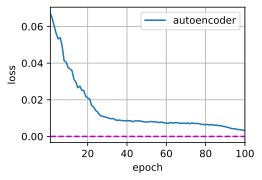

In [26]:
train_autoencoder(train_loader, 100)

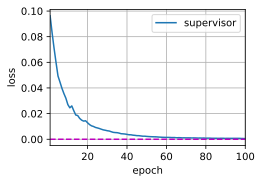

In [27]:
train_supervisor(train_loader, 100)

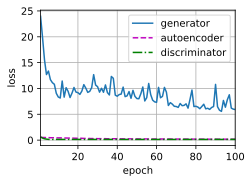

In [36]:
D_losses = train_joint(train_loader, 100)

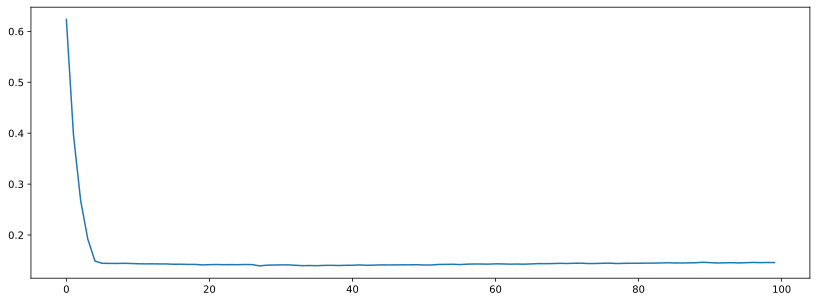

In [37]:
# Discriminator losses, zoomed in
plt.plot(D_losses)

### Comments on training

We can see that the generator improves very slowly, if at all, in the last 70 epochs of training. At the same time, we see that the discriminator stops being updated extremely early in the training process. Therefore, we guess that we may see an improvement in the generator if we slow down the discriminator training further, based on the idea that we want the generator and discriminator to improve at the same 'rate', rather than the discriminator learning very quickly as it does here. We leave this experiment for a future work. 

### Save/load model parameters

In [ ]:
# Save model parameters

suffix = "__placeholder__"

torch.save(embedding.state_dict(), f"trained_TimeGAN/embedding{suffix}")
torch.save(recovery.state_dict(), f"trained_TimeGAN/recovery{suffix}")
torch.save(subgenerator.state_dict(), f"trained_TimeGAN/subgenerator{suffix}")
torch.save(supervisor.state_dict(), f"trained_TimeGAN/supervisor{suffix}")
torch.save(discriminator.state_dict(), f"trained_TimeGAN/discriminator{suffix}")

In [43]:
# Load model parameters

'''
Trained model suffixes:
"_50e_no_init": lots of periodicity, short periods in stacked version. Lots of noise in sequential
"_50e_with_init": longer periods. Lots of noise in sequential (currently best model)
"_50e_with_init_zs6": z_size=6. For all the other models we use z_size=24, it seems to work better
"_500e_with_init_zs24": No better than _50e_with_init!! In fact, generated samples are EXACTLY the same.
"_100e_with_init_zs24_nl1_sl255": Trained on S&P data. num_layers=1, sequence_length=255
'''

suffix = "_100e_with_init_zs24_nl1_sl255"

embedding.load_state_dict(torch.load(f"trained_TimeGAN/embedding{suffix}"))
recovery.load_state_dict(torch.load(f"trained_TimeGAN/recovery{suffix}"))
subgenerator.load_state_dict(torch.load(f"trained_TimeGAN/subgenerator{suffix}"))
supervisor.load_state_dict(torch.load(f"trained_TimeGAN/supervisor{suffix}"))
discriminator.load_state_dict(torch.load(f"trained_TimeGAN/discriminator{suffix}"))

<All keys matched successfully>

# Evaluation

After performing a manual visual inspection, we use a combination of the evaluation methods in the FinGAN paper and the TimeGAN paper. First, we check whether volatility clustering and heavy tails can be observed in the generated time series. Then, we use tSNE to visualise the joint distributions of the real and generated time series in 2D, and inspect how similar they are. 

* Train an RNN time series classifier (or get a pre-trained one, which would probably be better) to distinguish between the original and synthetic time series. If the synthetic ones are realistic, we would expect that this RNN classifier gets an accuracy of around 50% on a held-out test set.
* A variation of Train Synthetic Test Real, to see whether TimeGAN captures the conditional distributions in the training data. 

References: 
* https://towardsdatascience.com/visualising-high-dimensional-datasets-using-pca-and-t-sne-in-python-8ef87e7915b

In [45]:
# Define helper functions
def generate(Z):
    '''
    Generates synthetic time series of length sequence_length
    when given a noise vector of shape (1, sequence_length, z_size)
    '''
    E_hat = subgenerator(Z)
    H_hat = supervisor(E_hat)
    X_hat = recovery(H_hat)
    return X_hat

def stack(X):
    '''
    (Helper function)
    Since TimeGAN was trained on a multivariate series,
    we stack the data so it is as if we had univariate 
    series 
    '''
    X_stacked = []
    for multivariate_window in X:
        for variate in range(input_size):
            X_stacked.append(multivariate_window.T[variate])

    X_stacked = np.array(np.vstack(X_stacked))

    return X_stacked

In [46]:
generated_data = generate(torch.randn(X.shape[0], sequence_length, z_size)).detach().numpy()

### Visual Inspection

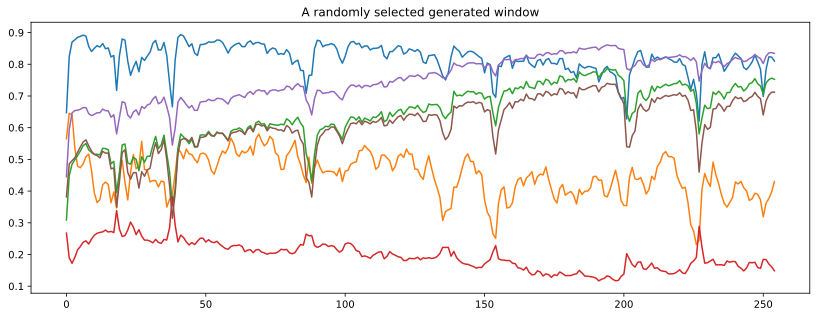

In [47]:
# Plot a randomly selected generated window
plt.title("A randomly selected generated window")
plt.plot(np.array(generated_data)[random.sample(list(np.arange(generated_data.shape[0])), 1)[0]]);

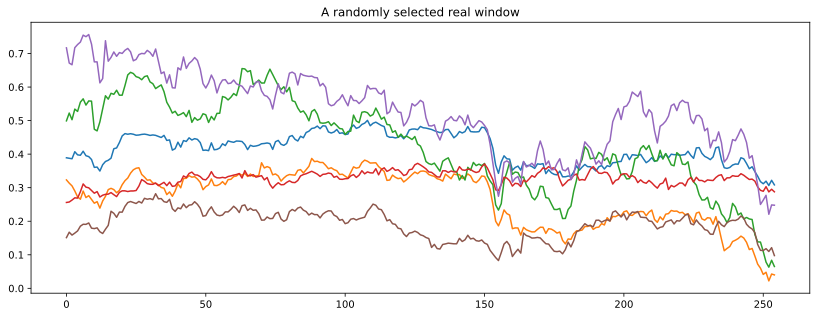

In [48]:
# Plot a randomly selected real window
plt.title("A randomly selected real window")
plt.plot(np.array(X)[random.sample(list(np.arange(X.shape[0])), 1)[0]]);

### Checking financial time series characteristics

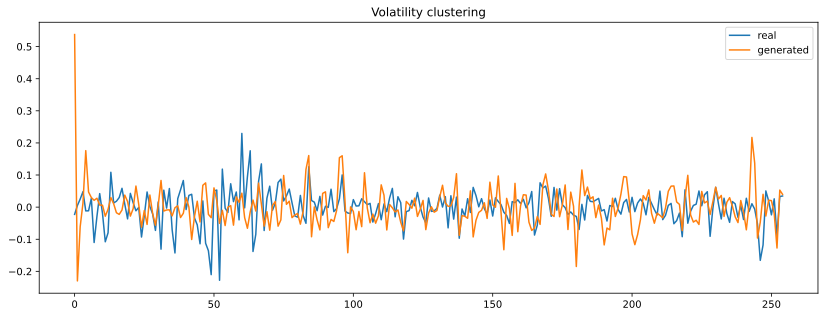

In [49]:
# Randomly select windows to visualise
real_series = stack(X)[random.sample(list(np.arange(stack(X).shape[0])), 1)].T
generated_series = stack(generated_data)[random.sample(list(np.arange(stack(generated_data).shape[0])), 1)].T

# Calculate log returns
real_rets = np.log(real_series) - np.log(np.roll(real_series, 1))
generated_rets = np.log(generated_series) - np.log(np.roll(generated_series, 1))

plt.title("Volatility clustering")
plt.plot(real_rets, label="real")
plt.plot(generated_rets, label="generated")
plt.legend();

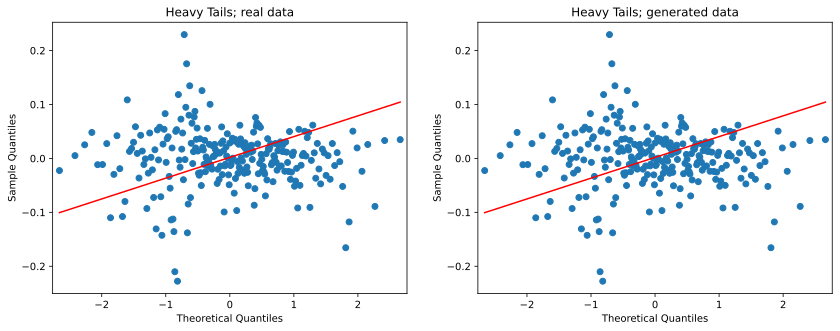

In [50]:
fig, ax = plt.subplots(1, 2, figsize=(14, 5))
ax[0].set_title("Heavy Tails; real data")
sm.qqplot(real_rets, line='q', ax=ax[0])
ax[1].set_title("Heavy Tails; generated data")
sm.qqplot(real_rets, line='q', ax=ax[1])
plt.show()

### tSNE visualisation

tSNE is an algorithm which allows us to visualise high-dimensional vectors in 2D space. It is designed in such a way that two vectors that are close together in high-dimensional space will also be close together in the lower-dimensional 2D space, and vice versa. Thus, if the distributions of the real and generated data appear similar in the 2D plot, we can infer that the distributions of real and generated data are similar in their original high-dimensional space. 

In [51]:
def visualise_tSNE(real, generated):
    tSNE_real = TSNE(learning_rate = 50, init='random') #Learning rate is typically between 10 and 1000
    tSNE_generated = TSNE(learning_rate = 50,  init='random') #Learning rate is typically between 10 and 1000

    tsne_features_real = tSNE_real.fit_transform(real)
    tsne_features_generated = tSNE_generated.fit_transform(generated)

    df_tsne_features_real = pd.DataFrame()
    df_tsne_features_real['x'] = tsne_features_real[:, 0]
    df_tsne_features_real['y'] = tsne_features_real[:, 1]
    df_tsne_features_real['type'] = ["real"] * len(tsne_features_real[:, 0])

    df_tsne_features_generated = pd.DataFrame()
    df_tsne_features_generated['x'] = tsne_features_generated[:, 0]
    df_tsne_features_generated['y'] = tsne_features_generated[:, 1]
    df_tsne_features_generated['type'] = ["generated"] * len(tsne_features_generated[:, 0])

    df_tsne_features = pd.concat([df_tsne_features_real, df_tsne_features_generated], axis=0, sort=False)

    sns.scatterplot(x = "x", y = "y", hue="type", data = df_tsne_features)

In [52]:
visualise_tSNE(stack(X), stack(generated_data))

# Conclusion

The results for TimeGAN are not as good as we expected, given the results obtained by the authors of the TimeGAN paper (in particular, their tSNE plots showed much more overlap between real and generated distributions). While TimeGAN seems to be able to reproduce volatility clusters, and does not perform poorly on a visual inspection test, it is nowhere close to reproducing heavy tails and has a much higher JS divergence than even FinGAN. We suggest two main explanations for this. 

Firstly, our model generates sequences which are around ten times longer than the sequences generated by the authors of TimeGAN (assuming that the results in the paper were obtained using Yoon's implementation on GitHub), so the learning task is much more difficult. This is a limitation of choosing to use TimeGAN to generate financial time series, and compare to FinGAN, since the generated series need to be long enough to observe characteristics like volatility clustering and heavy tails. 

Secondly, we believe the learning process could be improved by tuning hyperparameters like the learning rate, the threshold at which the discriminator stops being updated (it is set to 0.15 in this implementation), how often the discriminator is updated, and others. This is left for a future work; we were not able to complete this process due to time constraints. 

Below, we comment on some other aspects of our TimeGAN implementation which could be improved in a future work. 

#### Data
Right now, the entire dataset is scaled using a single scaler. If we really want price series to be homogeneous, we could scale each extracted window individually. We could also experiment with including more variates in the time series (i.e. asking TimeGAN to model more asset prices), or including fewer variates in the time series. 

#### Evalutation
Evaluate TimeGAN in a more quantitative way, starting with the two methods from the TimeGAN paper which we mentioned above. This will remedy another shortcoming of our current evaluation techniques, which is that we do not check whether either model was able to learn conditional distributions in the time series data.

#### A variation of TimeGAN 
We believe it is interesting to implement a version of TimeGAN with the following changes, noting that it may or may not be theoretically well-founded:

- The subgenerator generates a long time series when given noise as input.
- The supervisor structure is as it is now. But instead of processing a single 255-length window for every output of the subgenerator (which right now is a 255-length sequence), it processes all possible windows of length 255 in the long time series (i.e. len(long_time_series) - 255 of them). Then, we ask the supervisor optimiser to minimise the sum, mean, or some other function of all of these individual losses. 

We believe this structure allows the model to generate long time series, but with a slightly smaller increase in the number of parameters to be estimated compared to the situation where we just increased the parameter sequence_length on the current version of TimeGAN.

Another possible variation, with the same goal of generating longer time series, is the following:

- Make use of TimeGAN's ability to model static features (in addition to the time series features). The static feature we would give is a time variable T, which denotes where the 255-length sequence belongs in the context of some much longer time series. In other words, we would be able to give two parameters to the supergenerator: not only the noise vector, but also a time variable T, which encodes where the 255-length sequence belongs in the context of the long time series. E.g. T=0 means the 255-length window is supposed to represent the first 255 values of the long time series. 
- All other aspects of TimeGAN structure are unchanged. Once the TimeGAN is trained and we want to use it to generate synthetic data, we can pass the time variable T and a noise vector to the supergenerator to obtain generated series of length 255. We then concatenate these series in the appropriate order to obtain a longer time series. Of course, if we are doing this, we would probably specify TimeGAN to generate much shorter sequences than those of length 255, since we can just concatenate the outputs to get a long time series.

# References

- https://www.sciencedirect.com/science/article/abs/pii/S0378437119307277 (FinGAN Paper)
- https://papers.nips.cc/paper/2019/hash/c9efe5f26cd17ba6216bbe2a7d26d490-Abstract.html (TimeGAN paper)
- https://towardsdatascience.com/visualising-high-dimensional-datasets-using-pca-and-t-sne-in-python-8ef87e7915b (tSNE visualisation)
- https://github.com/jsyoon0823/TimeGAN/blob/master/timegan.py (The implementation by the authors of the TimeGAN paper in TensorFlow)
- https://github.com/stefan-jansen/synthetic-data-for-finance/blob/main/01_TimeGAN_TF2.ipynb (Another implementation in TensorFlow by Jansen)
- https://github.com/d9n13lt4n/timegan-pytorch (A PyTorch implementation of TimeGAN)
- https://www.kaggle.com/datasets/camnugent/sandp500 (S&P500 Kaggle dataset)